In [23]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime, date
from dateutil import tz
import glob

import matplotlib.patches as mpatches
from metpy.plots import USCOUNTIES
import geopandas
from cartopy import crs as ccrs

from Map import Map

In [24]:
FORECAST = '5day'
LOCATION = 'florida'

In [25]:
def get_gdf(qpf_forecast):
    product = {
        '3day': 'day13',
        '5day': '95e',
        '7day': '97e'
    }.get(qpf_forecast, '97e')
    
    gdf = geopandas.read_file(glob.glob(f'data/{product}*.shp')[0])
    return gdf

qpf = get_gdf(FORECAST)

In [26]:
# Set colors
qpf_cmap = {
    '0.01': '#80ff00',
    '0.10': '#00cd00',
    '0.25': '#008b00',
    '0.50': '#104e8b',
    '0.75': '#1e8fff',
    '1.00': '#00b2ee',
    '1.25': '#00eeee',
    '1.50': '#8968cd',
    '1.75': '#912cee',
    '2.00': '#8b008b',
    '2.50': '#8b0000',
    '3.00': '#cd0000',
    '4.00': '#ee3f00',
    '5.00': '#ff8000',
    '7.00': '#cd8500',
    '10.00': '#ffd900',
    '15.00': '#ffff00',
    '20.00': '#ffaeb9'
}

# Generate legend patches
legend_patches = []
for val in qpf_cmap.keys():
   patch = mpatches.Patch(color=qpf_cmap[val], label=val)
   legend_patches.append(patch)

In [27]:
# Get time data
start_time = qpf.iloc[0]['START_TIME']
end_time = qpf.iloc[0]['END_TIME']

from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')

def get_valid_day(string):
    utc_time = datetime.strptime(string, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    valid_day = datetime.strftime(eastern, '%A').lstrip('0').replace(' 0', ' ')
    return valid_day

valid_day_start = get_valid_day(start_time)
valid_day_end = get_valid_day(end_time)

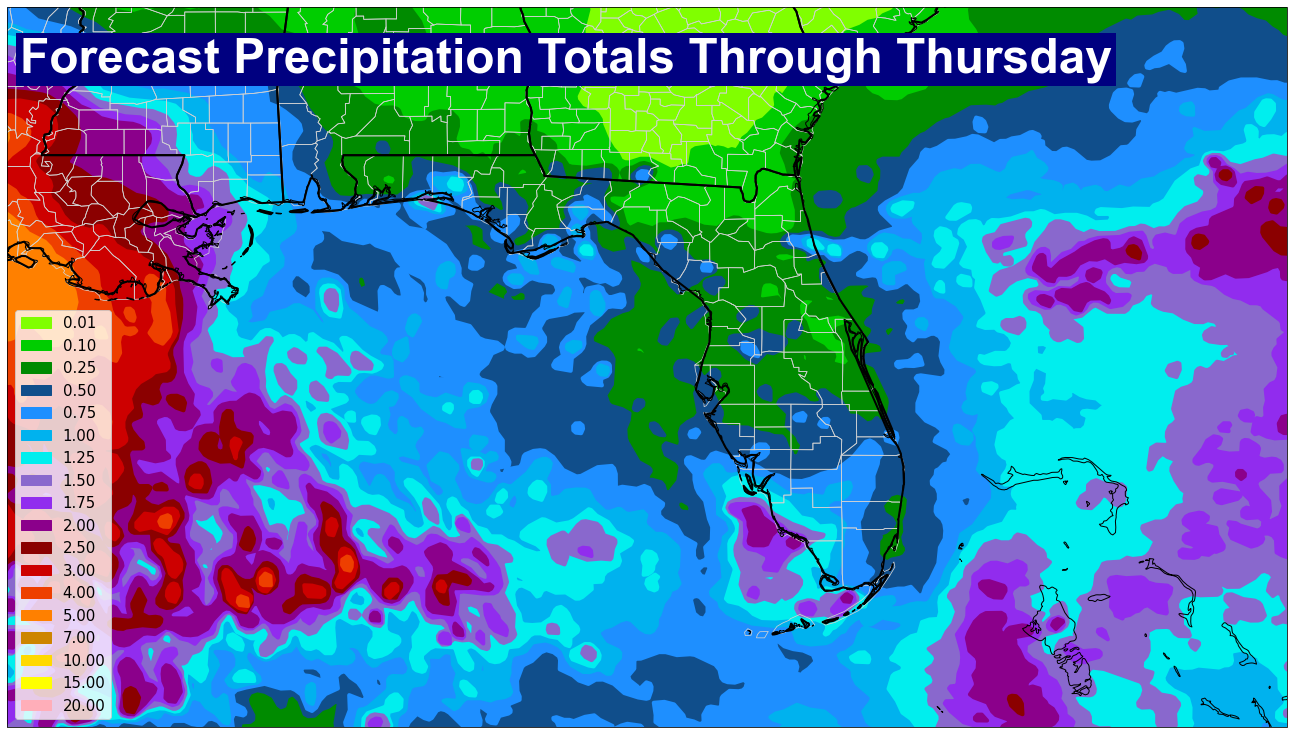

In [28]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.remove_international_states()
new_map.add_title(f'Forecast Precipitation Totals Through {valid_day_end}')

fig, ax = new_map.make_map()

for key in qpf_cmap:
    geometries = qpf[qpf['QPF'] == float(key)]
    ax.add_geometries(geometries['geometry'], crs=ccrs.PlateCarree(), facecolor=qpf_cmap[key], 
                      edgecolor=qpf_cmap[key], linewidth=4, zorder=0, alpha=1.0)
    

# Plot the legend
ax.legend(handles=legend_patches, fontsize=15, loc='lower left',)

graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'wpc'
fig.savefig(f'{graphics_dir}/qpf_day1to7.png', dpi=72)